Loading and preparing data...
✅ Loaded 35 selected features.

Training set: 38742 samples
Validation set: 9686 samples
Test set: 9126 samples

Class distribution in training set:
is_prospect
1    0.5
0    0.5
Name: proportion, dtype: float64


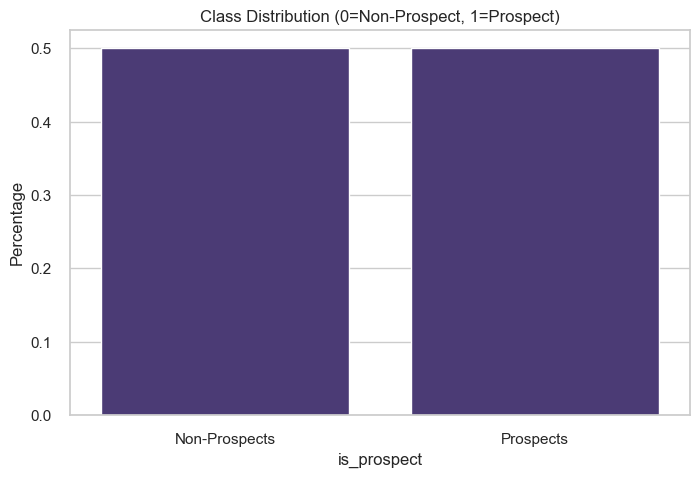


Training models...

Class Distribution:
is_prospect
1    19371
0    19371
Name: count, dtype: int64
Imbalance Ratio: 1.0:1
ℹ️ Data nearly balanced (ratio=1.00), skipping SMOTE
ℹ️ Data nearly balanced (ratio=1.00), skipping SMOTE
ℹ️ Data nearly balanced (ratio=1.00), skipping SMOTE
ℹ️ Data nearly balanced (ratio=1.00), skipping SMOTE
ℹ️ Data nearly balanced (ratio=1.00), skipping SMOTE
ℹ️ Data nearly balanced (ratio=1.00), skipping SMOTE
ℹ️ Data nearly balanced (ratio=1.00), skipping SMOTE

Tuning and training XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}
Best CV AUC for XGBoost: 0.9917

Tuning and training LightGBM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 19371, number of negative: 19371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057154 seconds.
You can

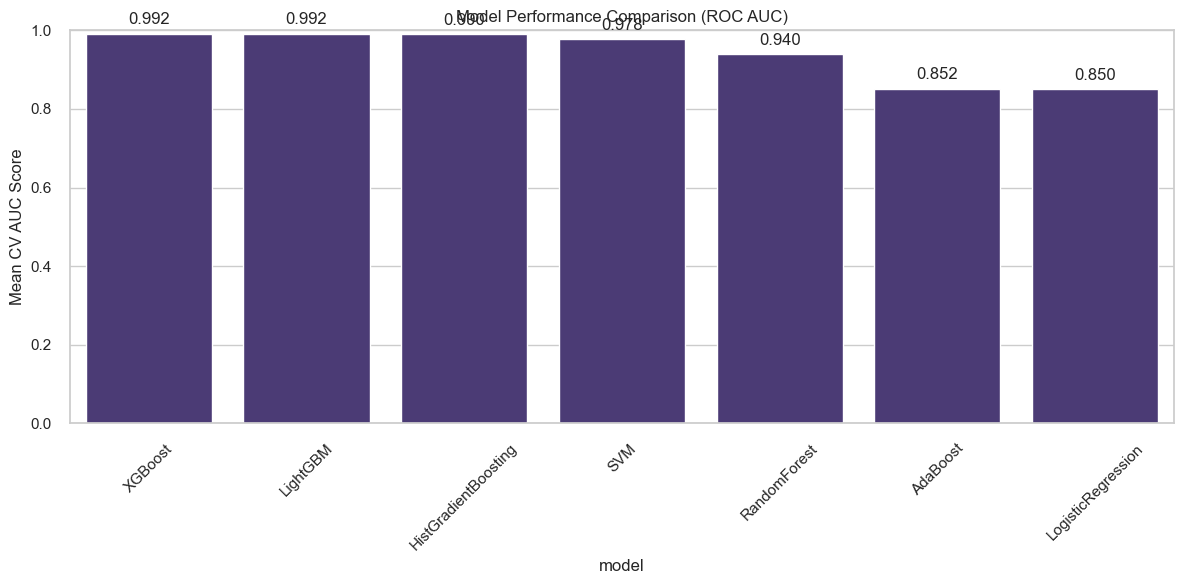


Saving models and artifacts...
Models and artifacts saved to C:\Users\Nanaba\Desktop\football_player_scouting_ml\models\prospect_models_v1

Top Features by Importance:

XGBoost:


num__skill_moves                  0.143712
remainder__playmaking_score       0.130201
remainder__mentality_vision       0.086700
remainder__power_index            0.064427
remainder__player_positions_CB    0.059896
num__value_eur                    0.031105
num__physic                       0.029622
num__skill_index                  0.029610
num__passing                      0.028720
num__pace                         0.027366
dtype: float32

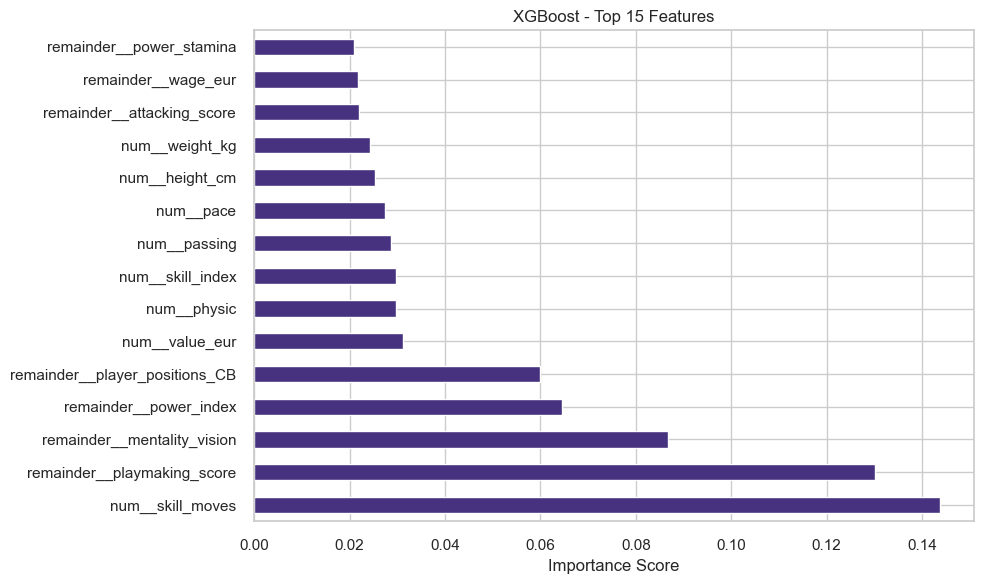


LightGBM:


num__value_eur                    492
num__passing                      374
remainder__mentality_composure    336
remainder__wage_ratio             267
num__pace                         260
remainder__mentality_vision       250
remainder__skill_ball_control     241
remainder__attacking_score        234
num__height_cm                    221
num__value_efficiency             210
dtype: int32

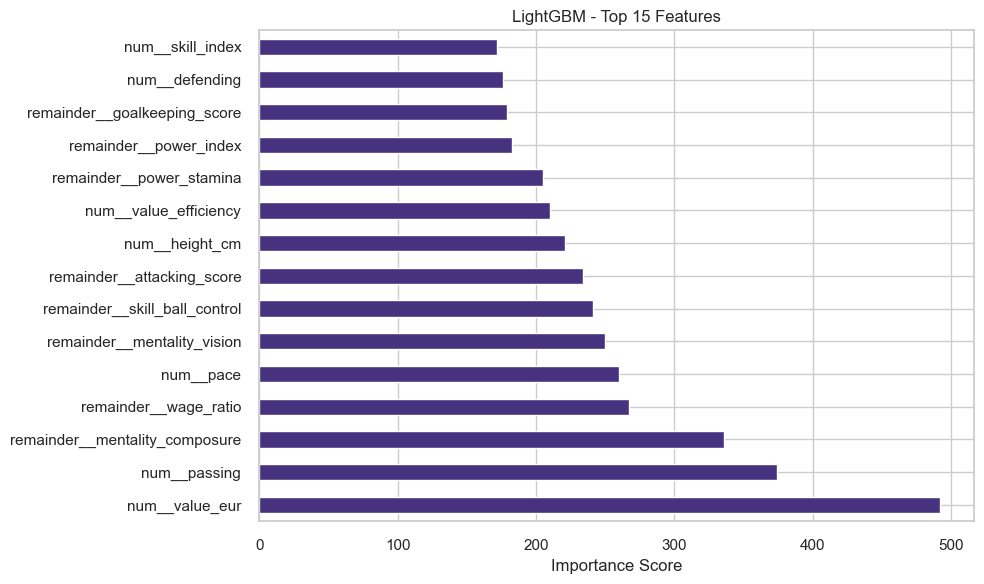


RandomForest:


remainder__playmaking_score       0.099322
remainder__mentality_vision       0.080712
remainder__skill_ball_control     0.066684
num__skill_moves                  0.064420
remainder__power_index            0.060862
remainder__attacking_finishing    0.059366
num__skill_index                  0.052026
num__value_eur                    0.049684
num__dribbling                    0.049341
num__pace                         0.038168
dtype: float64

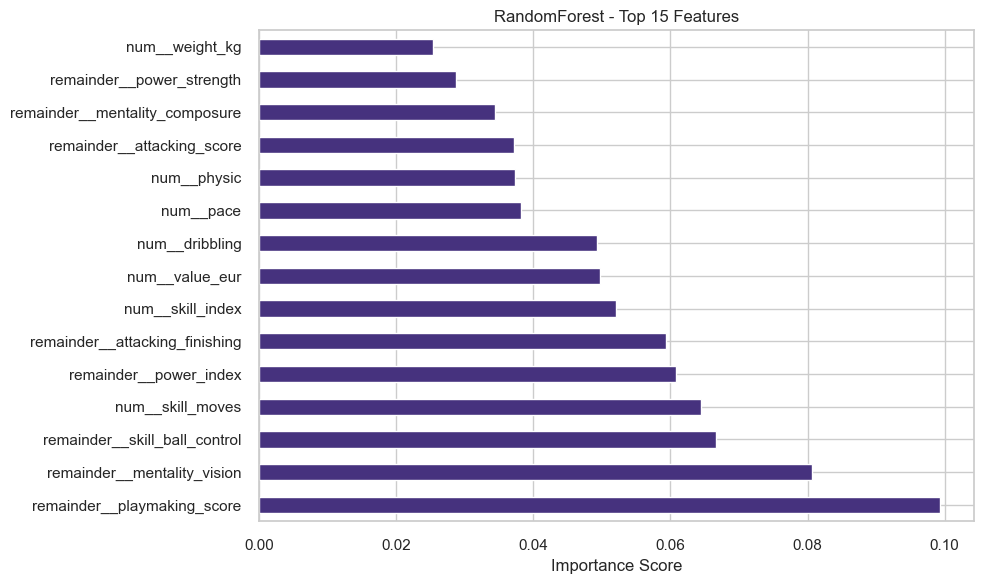


LogisticRegression:


num__physical_ratio               2.552693
num__value_efficiency             2.296491
num__weight_kg                    1.689284
remainder__goalkeeping_score      1.490071
remainder__player_positions_GK    1.410107
num__passing                      1.360829
num__attack_defense_ratio         1.217268
remainder__attacking_score        1.135249
num__height_cm                    1.115069
remainder__skill_long_passing     0.866086
dtype: float64

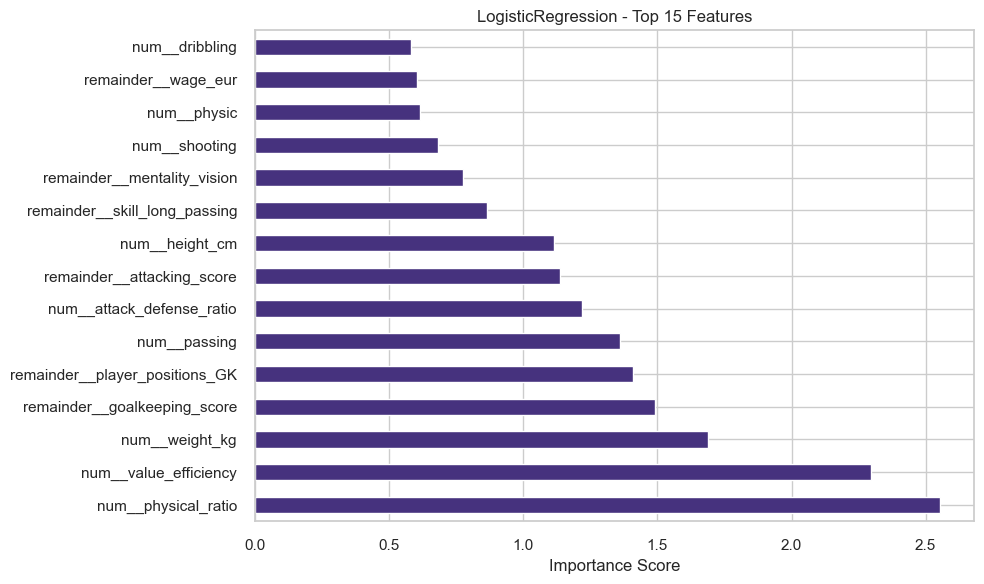


AdaBoost:


remainder__playmaking_score      0.482309
remainder__skill_ball_control    0.201885
remainder__mentality_vision      0.109554
num__skill_index                 0.037321
remainder__power_index           0.035638
num__physic                      0.033840
num__pace                        0.029935
num__skill_moves                 0.029176
num__value_eur                   0.024202
num__weight_kg                   0.006575
dtype: float64

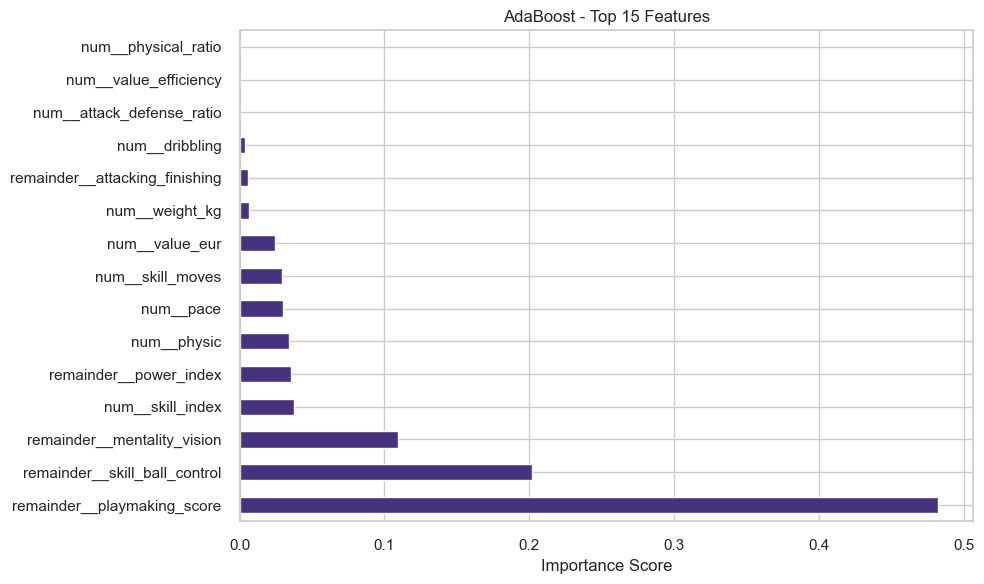


Training pipeline completed successfully!


In [2]:
# %% [markdown]
# Setup environment
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path
project_root = Path(r"C:\Users\Nanaba\Desktop\football_player_scouting_ml")
sys.path.insert(0, str(project_root / "src"))

# Import your training module
from model_training import ProspectModelTrainer

# Visualization setup
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid", palette="viridis")
%matplotlib inline

# %%
# Configuration
config = {
    "paths": {
        "features_train": project_root / "data" / "leakproof_features" / "processed_train.feather",
        "features_val": project_root / "data" / "leakproof_features" / "processed_val.feather",  # Added validation path
        "features_test": project_root / "data" / "leakproof_features" / "processed_test.feather",
        "selected_features": project_root / "data" / "leakproof_features" / "selected_features.pkl",
        "output": project_root / "models" / "prospect_models_v1"
    },
    "models": {  # Added missing comma after paths block
        "XGBoost": {
            "n_estimators": 200,
            "max_depth": 6,
            "learning_rate": 0.1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "random_state": 42,
            "eval_metric": "logloss"
        },
        "LightGBM": {
            "n_estimators": 200,
            "max_depth": 5,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "random_state": 42
        },
        "RandomForest": {
            "n_estimators": 200,
            "max_depth": 8,
            "min_samples_split": 5,
            "random_state": 42
        },
        "HistGradientBoosting": {
            "max_iter": 200,
            "max_depth": 5,
            "learning_rate": 0.05,
            "random_state": 42
        },
        "LogisticRegression": {
            "penalty": "elasticnet",
            "solver": "saga",
            "l1_ratio": 0.5,
            "max_iter": 1000,
            "random_state": 42
        },
        "SVM": {
            "probability": True,
            "kernel": "rbf",
            "C": 1.0,
            "random_state": 42
        },
        "AdaBoost": {
            "n_estimators": 200,
            "learning_rate": 0.1,
            "random_state": 42
        }
    },
    "training": {
        "test_size": 0.2,
        "random_state": 42,
        "smote_k_neighbors": 3,
        "smote_sampling_strategy": 0.33,  # Adjusted to safer value
        "cv_folds": 5,
        "metrics": ["roc_auc", "average_precision"],
        "feature_selection": True,
        "enable_smote": True  # Added flag to control SMOTE usage
    }
}

# %%
# Initialize the trainer
trainer = ProspectModelTrainer(config)

# %%
# Load and prepare data (now with validation set)
print("Loading and preparing data...")
X_train, X_val, X_test, y_train, y_val, y_test = trainer.load_and_prepare_data()

# Show dataset info
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print("\nClass distribution in training set:")
class_dist = pd.Series(y_train).value_counts(normalize=True)
print(class_dist)

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Class Distribution (0=Non-Prospect, 1=Prospect)')
plt.ylabel('Percentage')
plt.xticks([0, 1], ['Non-Prospects', 'Prospects'])
plt.show()

# %%
# Train models (pass validation data)
print("\nTraining models...")
results = trainer.train_models(X_train, X_val, X_test, y_train, y_val, y_test)

# Create a clean results dictionary with only numeric metrics
clean_results = {}
for model_name, metrics in results.items():
    clean_metrics = {
        'cv_mean_auc': float(metrics['cv_mean_auc']),
        'cv_std_auc': float(metrics['cv_std_auc'])
    }
    clean_results[model_name] = clean_metrics

# Convert to DataFrame
results_df = pd.DataFrame.from_dict(clean_results, orient='index').reset_index()
results_df = results_df.rename(columns={'index': 'model'})
results_df = results_df.sort_values('cv_mean_auc', ascending=False)

# Verify the DataFrame structure
print("\nResults DataFrame structure:")
print(results_df.head())
print("\nData types:")
print(results_df.dtypes)

# Plot with proper data validation
plt.figure(figsize=(12, 6))
try:
    # Ensure data is numeric
    results_df['cv_mean_auc'] = pd.to_numeric(results_df['cv_mean_auc'])
    
    ax = sns.barplot(
        x='model', 
        y='cv_mean_auc', 
        data=results_df,
        order=results_df.sort_values('cv_mean_auc', ascending=False)['model']
    )
    
    # Add value labels
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.3f}", 
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', 
            xytext=(0, 10), 
            textcoords='offset points'
        )
    
    plt.title('Model Performance Comparison (ROC AUC)')
    plt.ylabel('Mean CV AUC Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating plot: {e}")
    print("Debug info - results_df contents:")
    print(results_df)

# %%
# Save models and artifacts
print("\nSaving models and artifacts...")
trainer.save_models_and_artifacts()

# %%
# Feature importance visualization (if available)
if hasattr(trainer, 'feature_importances') and trainer.feature_importances:
    print("\nTop Features by Importance:")
    for model_name, importance in trainer.feature_importances.items():
        if importance is not None:
            print(f"\n{model_name}:")
            display(importance.head(10))
            
            plt.figure(figsize=(10, 6))
            importance.head(15).plot(kind='barh')
            plt.title(f'{model_name} - Top 15 Features')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()

print("\nTraining pipeline completed successfully!")
